In this notebook, we will again build on the advances we made in the last notebook. We saw that the model is currently failing to properly converge. While the most probable explanation are shortcomings in the aesthetic predictor model, we may also improve convergence by adding an additional parameter, which is the background color. So lets introduce this parameter:

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
from lion_pytorch import Lion

In [28]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [29]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

In [30]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


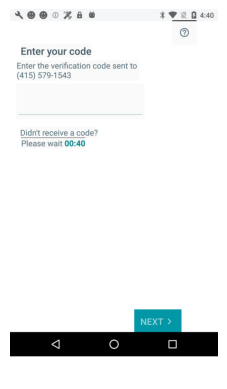

In [31]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

In [32]:
#optimizer = torch.optim.SGD(msUIo_wbg.parameters(), lr=0.01, momentum=0.9)
optimizer = Lion(msUIo_wbg.parameters(), lr=15e-3, weight_decay=1e-2)

aesthetic_predictor = AestheticPredictor()

In [33]:
scores = []
images_for_gif = []

for x in tqdm.tqdm(range(20)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = aesthetic_predictor(generated_image.unsqueeze(0))

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    pbar.set_description(f"Score: {score}")
    pbar.refresh()

print(f"Final Score: {score[-1]}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:02<00:00, 21.15s/it]

Final Score: tensor([4.7534], grad_fn=<SelectBackward0>)


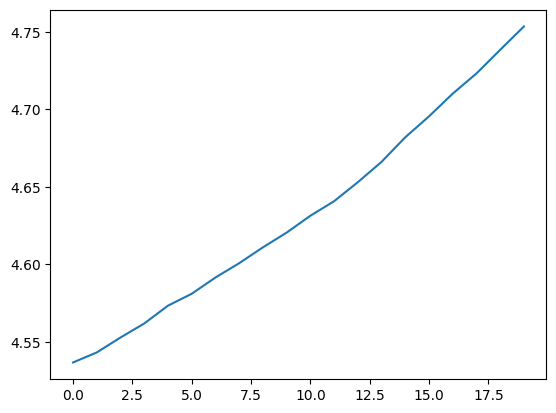

In [34]:
plt.plot(scores)
plt.show()

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_51340/2186966717.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_51340/2186966717.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



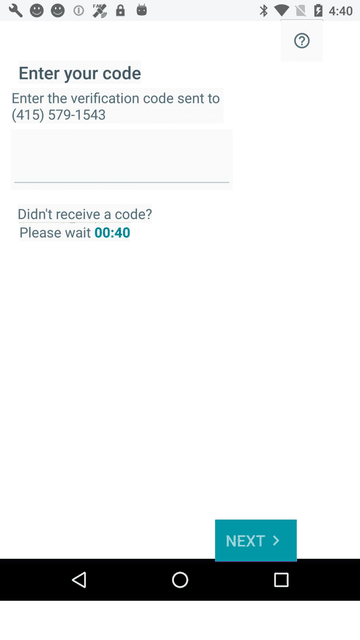

In [35]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))
imageio.mimsave('./progress.gif', images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open('./progress.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


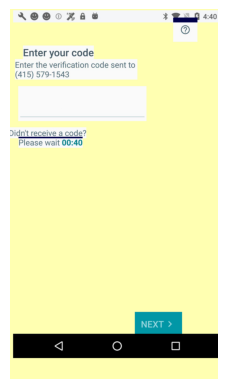

In [36]:
canvasses = msUIo_wbg()

generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

As you can see, the ui does not particularly look good. This is most probably due to issues with the aesthetics predictor. In the next notebook we will try another predictor, which is based on a different paper and different model architecture.

In [37]:
#https://dl.acm.org/doi/pdf/10.1145/3554364.3559113